In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, Input, GlobalAveragePooling1D, Flatten
import tensorflow_hub as hub

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [84]:
!pip install tensorflow-text
import tensorflow_text

In [85]:
df = pd.read_csv("data/train.csv")
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [86]:
# pip install tensorflow_hub

In [87]:
df.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,859f1081f7ba,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [88]:
df = df.drop_duplicates(subset ="discourse_text")
df = df.drop(columns=['essay_id', 'discourse_type'])
df = df.reset_index(drop = True)

C:\Users\e175932\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='discourse_effectiveness', ylabel='count'>

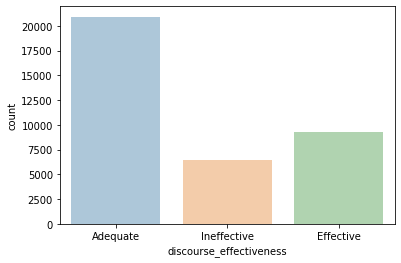

In [89]:
sns.countplot(df['discourse_effectiveness'], alpha = 0.4)

In [90]:
df.isna().sum()

discourse_id               0
discourse_text             0
discourse_effectiveness    0
dtype: int64

In [91]:
#One hot encode label

label_dummies = pd.get_dummies(df['discourse_effectiveness'])
df = pd.concat([df.drop(columns='discourse_effectiveness'), label_dummies], axis=1)

#label
# df['label'] = df['discourse_effectiveness'].apply(lambda x: 2 if x == 'Effective' else 1 if x == 'Adequate'else 0)
# df = df.drop(columns='discourse_effectiveness')
# df = df.drop(columns='essay_id')
df.head()

,discourse_id,discourse_text,Adequate,Effective,Ineffective
0,0013cc385424,"Hi, i'm Isaac, i'm going to be writing about h...",1,0,0
1,9704a709b505,"On my perspective, I think that the face is a ...",1,0,0
2,c22adee811b6,I think that the face is a natural landform be...,1,0,0
3,a10d361e54e4,"If life was on Mars, we would know by now. The...",1,0,0
4,db3e453ec4e2,People thought that the face was formed by ali...,1,0,0


In [92]:
#train_text_split
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(29352, 5) (7339, 5)


In [93]:
X_train=df_train["discourse_text"]
X_test=df_test["discourse_text"]
X_train.shape

(29352,)

In [94]:
label_class = ['Adequate', 'Effective', 'Ineffective']
Y_train = df_train[label_class].values
Y_test = df_test[label_class].values
Y_train.shape

(29352, 3)

In [95]:
def our_Bert_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2", trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]      # [batch_size, 128].
    net = Dense(64, activation = 'relu')(net)
    net = Dropout(0.1)(net)
    net = Dense(32, activation = 'relu')(net)
    net = Dropout(0.1)(net)
    net = Dense(3, activation = 'softmax', name = 'classifier')(net)
    return tf.keras.Model(text_input, net)

our_model = our_Bert_model()
our_model.summary()
our_model.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_type_ids':   0           ['input_9[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_Bert_embedding', monitor = 'val_loss')
history = our_model.fit(
x = X_train, y = Y_train, epochs= 50, validation_data=(X_test, Y_test),
callbacks= [callback_model])

Epoch 1/50
918/918 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.5741

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 838s 909ms/step - loss: 0.9679 - accuracy: 0.5741 - val_loss: 0.9807 - val_accuracy: 0.5659
Epoch 2/50
918/918 [==============================] - ETA: 0s - loss: 0.9764 - accuracy: 0.5708

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 826s 900ms/step - loss: 0.9764 - accuracy: 0.5708 - val_loss: 0.9798 - val_accuracy: 0.5659
Epoch 3/50
918/918 [==============================] - ETA: 0s - loss: 0.9762 - accuracy: 0.5710

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 883s 963ms/step - loss: 0.9762 - accuracy: 0.5710 - val_loss: 0.9799 - val_accuracy: 0.5659
Epoch 4/50
918/918 [==============================] - ETA: 0s - loss: 0.9750 - accuracy: 0.5710

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 900s 980ms/step - loss: 0.9750 - accuracy: 0.5710 - val_loss: 0.9797 - val_accuracy: 0.5659
Epoch 5/50
918/918 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.5710

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 898s 978ms/step - loss: 0.9745 - accuracy: 0.5710 - val_loss: 0.9810 - val_accuracy: 0.5659
Epoch 6/50
918/918 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.5710

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 1085s 1s/step - loss: 0.9744 - accuracy: 0.5710 - val_loss: 0.9804 - val_accuracy: 0.5659
Epoch 7/50
918/918 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.5710

INFO:tensorflow:Assets written to: model_Bert_embedding\assets


INFO:tensorflow:Assets written to: model_Bert_embedding\assets


918/918 [==============================] - 1063s 1s/step - loss: 0.9742 - accuracy: 0.5710 - val_loss: 0.9802 - val_accuracy: 0.5659
Epoch 8/50
848/918 [==========================>...] - ETA: 34:02 - loss: 0.9734 - accuracy: 0.5715

In [ ]:
# save model
from tensorflow.keras.models import load_model
our_model.save('model_Bert.h5')

In [ ]:
losses = pd.DataFrame(our_model.history.history)
plt.figure(figsize=(12,8))
losses.plot()

### Predict and submit

In [ ]:
# test = pd.read_csv("data/test.csv")
# X_test2 = test['discourse_text'])
# pred5 = our_model.predict(X_test2)

In [ ]:
# pred5

In [ ]:
# submission = pd.DataFrame()
# submission['discourse_id'] = test['discourse_id']
# submission['Ineffective'] = p_pred5[:,0]
# submission['Adequate'] = p_pred5[:,1]
# submission['Effective'] = p_pred5[:,2]
# submission.to_csv("submission_bert1.csv", )